In [34]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from statsmodels.stats.multitest import multipletests
import warnings
import json
import os
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import glob

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Analysis timestamp: {TIMESTAMP}")
print("Libraries loaded successfully!")

Analysis timestamp: 20260112_233208
Libraries loaded successfully!


## 1. Configuration



In [35]:
# =============================================================================
# CONFIGURATION - MODIFY THESE PATHS TO MATCH YOUR DATA
# =============================================================================

# Base path for results
RESULTS_BASE_PATH = '/home/smotaali/BGP_Traffic_Generation/results_evaluation'

# Output directory
OUTPUT_DIR = f'{RESULTS_BASE_PATH}/comprehensive_evaluation/{TIMESTAMP}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Real datasets for comparison
REAL_DATASETS = {
    'rrc05_same': '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_discovered.csv',
    'rrc04_different': '/home/smotaali/BGP_Traffic_Generation/results_zend/final_label_results_HDBSCAN/rrc04_updates_20251116_extracted_discovered.csv'
}

# =============================================================================
# SYNTHETIC DATASETS - UPDATE PATHS FOR YOUR DATA
# =============================================================================
# Structure: 'method_name': {'same_rrc05': path, 'diff_rrc04': path}

SYNTHETIC_DATASETS = {
    # SCAPY (direct generation - only one version)
    'SCAPY': {
        'generated': '/home/smotaali/BGP_Traffic_Generation/results_zend/Scapy_enhanced_1215_v3'  # Path to SCAPY generated CSV
    },
    
    # GAN Default Values
    'GAN_LSTM_default': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs/Correlation_GAN_LSTM_rrc05',  # Evaluated on same rrc05 data
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs/Correlation_GAN_LSTM_rrc04'   # Evaluated on different rrc04 data
    },
    'GAN_TimeGAN_default': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs/Correlation_GAN_TIME_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs/Correlation_GAN_TIME_rrc04'
    },
    'GAN_DoppelGanger_default': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs/Correlation_GAN_Doppelganger_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs/Correlation_GAN_Doppelganger_rrc04'
    },
    
    # GAN Enhanced/Tuned Parameters
    'GAN_LSTM_enhanced': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs_improved/Correlation_GAN_LSTM_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs_improved/Correlation_GAN_LSTM_rrc04'
    },
    'GAN_TimeGAN_enhanced': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs_improved/Correlation_GAN_TIME_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs_improved/Correlation_GAN_TIME_rrc04'
    },
    'GAN_DoppelGanger_enhanced': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs_improved/Correlation_GAN_Doppelganger_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/gan_outputs_improved/Correlation_GAN_Doppelganger_rrc04'
    },
    
    # SMOTE Variants
    'SMOTE_normal': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/normal_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/normal_rrc04'
    },
    'SMOTE_borderline': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/borderline_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/borderline_rrc04'
    },
    'SMOTE_kmeans': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/kmeans_v3_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/kmeans_v3_rrc04'
    },
    'SMOTE_adasyn': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/adasyn_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_zend/SMOTE_enhanced/adasyn_rrc04'
    },
    
    # Hybrid (SMOTE + GAN)
    'Hybrid_SMOTE_GAN': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/synthetic_hybrid/compare_hybrid_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_huarie/results/synthetic_hybrid/compare_hybrid_rrc04'
    },
    
    # Copula
    'Copula': {
        'same_rrc05': '/home/smotaali/BGP_Traffic_Generation/results_zend/copula_rrc05',
        'diff_rrc04': '/home/smotaali/BGP_Traffic_Generation/results_zend/copula_rrc04'
    }
}

# Evaluation parameters
RANDOM_SEED = 42
ALPHA = 0.05

# KS statistic thresholds
KS_EXCELLENT_THRESHOLD = 0.05
KS_GOOD_THRESHOLD = 0.10
KS_MODERATE_THRESHOLD = 0.15

# Cohen's d cap
COHENS_D_CAP = 10.0

# Columns to exclude from analysis
EXCLUDE_COLS = [
    'timestamp', 'sequence_id', 'timestep', 'label', 'window_start', 'window_end',
    'discovered_label', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced'
]

# Feature importance weights for BGP semantics
FEATURE_IMPORTANCE_WEIGHTS = {
    # Core routing activity (highest importance)
    'announcements_rate': 2.0,
    'withdrawals_rate': 2.0,
    'announcements_count': 2.0,
    'withdrawals_count': 2.0,
    
    # Instability indicators
    'flap_count': 1.8,
    'flap_rate': 1.8,
    
    # Path dynamics
    'edit_dist_mean': 1.5,
    'edit_dist_max': 1.5,
    'path_length_mean': 1.5,
    'path_length_max': 1.5,
    
    # Prefix activity
    'unique_prefixes': 1.3,
    'prefix_announcements': 1.3,
    
    # AS-path related
    'unique_origins': 1.2,
    'avg_as_path_length': 1.2,
    
    # Default for other features
    '_default': 1.0
}

# Top K worst features to highlight
TOP_K_WORST = 10

print(f"Output directory: {OUTPUT_DIR}")
print(f"Configuration loaded!")

Output directory: /home/smotaali/BGP_Traffic_Generation/results_evaluation/comprehensive_evaluation/20260112_233208
Configuration loaded!


## 2. Helper Functions

In [36]:
def get_feature_columns(df: pd.DataFrame) -> List[str]:
    """Get feature columns excluding metadata"""
    return [col for col in df.columns if col not in EXCLUDE_COLS]


def get_upper_triangle(matrix: np.ndarray) -> np.ndarray:
    """Extract upper triangle elements from correlation matrix"""
    return matrix[np.triu_indices(len(matrix), k=1)]


def cohens_d(group1: pd.Series, group2: pd.Series, cap: float = COHENS_D_CAP) -> float:
    """Calculate Cohen's d effect size with capping"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    
    if n1 + n2 - 2 <= 0:
        return 0.0
    
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        if group1.mean() == group2.mean():
            return 0.0
        else:
            return cap if group1.mean() > group2.mean() else -cap
    
    d = (group1.mean() - group2.mean()) / pooled_std
    return np.clip(d, -cap, cap)


def interpret_cohens_d(d: float) -> str:
    """Interpret Cohen's d value"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return 'Negligible'
    elif abs_d < 0.5:
        return 'Small'
    elif abs_d < 0.8:
        return 'Medium'
    else:
        return 'Large'


def interpret_ks_statistic(ks_stat: float) -> str:
    """Interpret KS statistic threshold"""
    if ks_stat < KS_EXCELLENT_THRESHOLD:
        return 'Excellent'
    elif ks_stat < KS_GOOD_THRESHOLD:
        return 'Good'
    elif ks_stat < KS_MODERATE_THRESHOLD:
        return 'Moderate'
    else:
        return 'Poor'


def get_weight(feature: str) -> float:
    """Get importance weight for a feature"""
    return FEATURE_IMPORTANCE_WEIGHTS.get(feature, FEATURE_IMPORTANCE_WEIGHTS['_default'])


print("Helper functions defined!")

Helper functions defined!


In [37]:
# =============================================================================
# DIRECTORY LOADING FUNCTIONS - Handles directories with evaluation outputs
# =============================================================================

def find_csv_in_directory(dir_path: str) -> Optional[str]:
    """
    Find the appropriate CSV file in a directory containing evaluation outputs.
    
    Priority order:
    1. Look for raw synthetic data files (synthetic_*.csv, generated_*.csv)
    2. Look for combined data files that have both synthetic and real data
    3. Look for the detailed results from validation notebook
    """
    dir_path = Path(dir_path)
    
    if not dir_path.is_dir():
        return None
    
    # Priority 1: Look for raw synthetic data
    patterns_priority = [
        'synthetic_*.csv',
        'generated_*.csv',
        '*_synthetic.csv',
        '*_generated.csv',
    ]
    
    for pattern in patterns_priority:
        matches = list(dir_path.glob(pattern))
        if matches:
            print(f"    [Found raw synthetic data: {matches[0].name}]")
            return str(matches[0])
    
    # Priority 2: Look for any CSV that might contain synthetic data
    # (excluding known evaluation output files)
    evaluation_output_prefixes = [
        'enhanced_v3_',
        'calibration_',
    ]
    
    for csv_file in dir_path.glob('*.csv'):
        filename = csv_file.name
        is_evaluation_output = any(filename.startswith(prefix) for prefix in evaluation_output_prefixes)
        if not is_evaluation_output:
            print(f"    [Found potential data file: {csv_file.name}]")
            return str(csv_file)
    
    return None


def load_precomputed_results(dir_path: str) -> Optional[Dict]:
    """
    Load pre-computed evaluation results from a directory.
    Returns a dictionary with the same structure as evaluate_single_comparison().
    """
    dir_path = Path(dir_path)
    
    # Check for required files
    summary_file = dir_path / 'enhanced_v3_summary.csv'
    detailed_file = dir_path / 'enhanced_v3_detailed_results.csv'
    ks_file = dir_path / 'enhanced_v3_ks_results.csv'
    effect_file = dir_path / 'enhanced_v3_effect_sizes.csv'
    pca_file = dir_path / 'enhanced_v3_pca_centroid_analysis.json'
    problematic_file = dir_path / 'enhanced_v3_problematic_features.json'
    
    if not summary_file.exists():
        return None
    
    print(f"    [Loading pre-computed results from directory]")
    
    # Load summary
    summary_df = pd.read_csv(summary_file)
    
    # Initialize results structure
    results = {
        'feature_metrics': [],
        'correlation_metrics': {},
        'multivariate_metrics': {},
        'overall_scores': {},
        'problematic_features': {'large_effect': [], 'poor_ks': [], 'high_wasserstein': []},
        'constant_features': {'constant_both': [], 'constant_synthetic_only': [], 'constant_real_only': []},
        'precomputed': True  # Flag to indicate these are pre-computed results
    }
    
    # Extract values from summary
    def get_summary_value(metric_name, default=0):
        row = summary_df[summary_df['Metric'] == metric_name]
        if not row.empty and 'Value' in row.columns:
            return float(row['Value'].values[0])
        return default
    
    # Try to get sample counts
    results['n_synthetic'] = int(get_summary_value('N_Synthetic', get_summary_value('n_synthetic', 1000)))
    results['n_real'] = int(get_summary_value('N_Real', get_summary_value('n_real', 1000)))
    
    # Load detailed results if available
    if detailed_file.exists():
        detailed_df = pd.read_csv(detailed_file)
        results['n_features'] = len(detailed_df)
        
        for _, row in detailed_df.iterrows():
            fm = {
                'feature': row.get('Feature', row.get('feature', '')),
                'ks_statistic': row.get('KS_Statistic', row.get('ks_statistic', 0)),
                'ks_pvalue': row.get('KS_PValue', row.get('ks_pvalue', 1)),
                'wasserstein_distance': row.get('Wasserstein', row.get('wasserstein_distance', 0)),
                'cohens_d': row.get('Cohens_d', row.get('cohens_d', 0)),
                'cohens_d_interpretation': row.get('Effect_Interpretation', row.get('cohens_d_interpretation', 'Unknown')),
                'similarity_level': row.get('Similarity_Level', row.get('similarity_level', 'Unknown')),
                'importance_weight': get_weight(row.get('Feature', row.get('feature', '')))
            }
            results['feature_metrics'].append(fm)
    elif ks_file.exists():
        # Fallback to KS results file
        ks_df = pd.read_csv(ks_file)
        results['n_features'] = len(ks_df)
        
        for _, row in ks_df.iterrows():
            feature = row.get('Feature', row.get('feature', ''))
            ks_stat = row.get('KS_Statistic', row.get('ks_statistic', 0))
            fm = {
                'feature': feature,
                'ks_statistic': ks_stat,
                'ks_pvalue': row.get('KS_PValue', row.get('ks_pvalue', 1)),
                'wasserstein_distance': row.get('Wasserstein', 0),
                'cohens_d': 0,
                'cohens_d_interpretation': 'Unknown',
                'similarity_level': interpret_ks_statistic(ks_stat),
                'importance_weight': get_weight(feature)
            }
            results['feature_metrics'].append(fm)
    else:
        results['n_features'] = int(get_summary_value('N_Features', 0))
    
    # Load effect sizes if available and not already loaded
    if effect_file.exists() and results['feature_metrics']:
        effect_df = pd.read_csv(effect_file)
        effect_dict = {}
        for _, row in effect_df.iterrows():
            feature = row.get('Feature', row.get('feature', ''))
            effect_dict[feature] = {
                'cohens_d': row.get('Cohens_d', row.get('cohens_d', 0)),
                'interpretation': row.get('Interpretation', row.get('cohens_d_interpretation', 'Unknown'))
            }
        
        for fm in results['feature_metrics']:
            if fm['feature'] in effect_dict:
                fm['cohens_d'] = effect_dict[fm['feature']]['cohens_d']
                fm['cohens_d_interpretation'] = effect_dict[fm['feature']]['interpretation']
    
    # Load PCA metrics if available
    if pca_file.exists():
        with open(pca_file, 'r') as f:
            pca_data = json.load(f)
        results['multivariate_metrics'] = {
            'pca_centroid_distance': pca_data.get('centroid_distance', pca_data.get('pca_centroid_distance', 0)),
            'pca_centroid_distance_2d': pca_data.get('centroid_distance_2d', pca_data.get('pca_centroid_distance_2d', 0)),
            'silhouette_score': pca_data.get('silhouette_score', np.nan)
        }
    else:
        results['multivariate_metrics'] = {
            'pca_centroid_distance': get_summary_value('PCA_Centroid_Distance', 0),
            'pca_centroid_distance_2d': 0,
            'silhouette_score': np.nan
        }
    
    # Load problematic features if available
    if problematic_file.exists():
        with open(problematic_file, 'r') as f:
            prob_data = json.load(f)
        results['problematic_features'] = {
            'large_effect': prob_data.get('large_effect', prob_data.get('large_effect_size', [])),
            'poor_ks': prob_data.get('poor_ks', prob_data.get('poor_distribution', [])),
            'high_wasserstein': prob_data.get('high_wasserstein', [])
        }
    
    # Calculate correlation metrics from summary or detailed data
    results['correlation_metrics'] = {
        'pearson_correlation': get_summary_value('Correlation_Pearson', get_summary_value('correlation_preservation', 0)),
        'spearman_correlation': get_summary_value('Correlation_Spearman', 0),
        'mean_abs_diff': get_summary_value('Correlation_Mean_Diff', 0)
    }
    
    # Calculate overall scores
    fm_list = results['feature_metrics']
    if fm_list:
        total_weight = sum(fm['importance_weight'] for fm in fm_list)
        n_features = len(fm_list)
        
        # Distribution score
        good_or_better_weighted = sum(
            fm['importance_weight'] for fm in fm_list
            if fm['similarity_level'] in ['Excellent', 'Good']
        )
        distribution_score_weighted = (good_or_better_weighted / total_weight) * 100 if total_weight > 0 else 0
        
        good_or_better = sum(1 for fm in fm_list if fm['similarity_level'] in ['Excellent', 'Good'])
        distribution_score_unweighted = (good_or_better / n_features) * 100 if n_features > 0 else 0
        
        # Correlation score
        correlation_score = ((results['correlation_metrics'].get('pearson_correlation', 0) + 1) / 2) * 100
        
        # Effect size score
        effect_weights = {'Negligible': 4, 'Small': 3, 'Medium': 2, 'Large': 1, 'Unknown': 2}
        effect_score_weighted = sum(
            effect_weights.get(fm['cohens_d_interpretation'], 2) * fm['importance_weight']
            for fm in fm_list
        ) / (4 * total_weight) * 100 if total_weight > 0 else 0
        
        effect_score_unweighted = sum(
            effect_weights.get(fm['cohens_d_interpretation'], 2)
            for fm in fm_list
        ) / (4 * n_features) * 100 if n_features > 0 else 0
        
        # Wasserstein score
        mean_wd = np.mean([fm['wasserstein_distance'] for fm in fm_list])
        wasserstein_score = max(0, 100 - mean_wd * 50)
        
        # PCA score
        pca_dist = results['multivariate_metrics'].get('pca_centroid_distance', 0)
        pca_score = max(0, 100 - pca_dist * 10)
        
        # Overall scores
        overall_weighted = (
            distribution_score_weighted * 0.30 +
            correlation_score * 0.20 +
            effect_score_weighted * 0.25 +
            wasserstein_score * 0.15 +
            pca_score * 0.10
        )
        
        overall_unweighted = (
            distribution_score_unweighted * 0.30 +
            correlation_score * 0.20 +
            effect_score_unweighted * 0.25 +
            wasserstein_score * 0.15 +
            pca_score * 0.10
        )
        
        results['overall_scores'] = {
            'distribution_score_weighted': distribution_score_weighted,
            'distribution_score_unweighted': distribution_score_unweighted,
            'correlation_score': correlation_score,
            'effect_size_score_weighted': effect_score_weighted,
            'effect_size_score_unweighted': effect_score_unweighted,
            'wasserstein_score': wasserstein_score,
            'multivariate_score': pca_score,
            'overall_score_weighted': overall_weighted,
            'overall_score_unweighted': overall_unweighted
        }
        
        # Update problematic features from feature metrics
        if not results['problematic_features']['large_effect']:
            results['problematic_features']['large_effect'] = [
                fm['feature'] for fm in fm_list if fm['cohens_d_interpretation'] == 'Large'
            ]
        if not results['problematic_features']['poor_ks']:
            results['problematic_features']['poor_ks'] = [
                fm['feature'] for fm in fm_list if fm['similarity_level'] == 'Poor'
            ]
        if not results['problematic_features']['high_wasserstein']:
            results['problematic_features']['high_wasserstein'] = sorted(
                [(fm['feature'], fm['wasserstein_distance']) for fm in fm_list],
                key=lambda x: x[1], reverse=True
            )[:TOP_K_WORST]
    else:
        # Use values from summary if no detailed metrics
        results['overall_scores'] = {
            'distribution_score_weighted': get_summary_value('Distribution_Score', 50),
            'distribution_score_unweighted': get_summary_value('Distribution_Score', 50),
            'correlation_score': get_summary_value('Correlation_Score', 50),
            'effect_size_score_weighted': get_summary_value('Effect_Size_Score', 50),
            'effect_size_score_unweighted': get_summary_value('Effect_Size_Score', 50),
            'wasserstein_score': get_summary_value('Wasserstein_Score', 50),
            'multivariate_score': get_summary_value('PCA_Score', 50),
            'overall_score_weighted': get_summary_value('Overall_Score', 50),
            'overall_score_unweighted': get_summary_value('Overall_Score', 50)
        }
    
    return results


def load_synthetic_data(path: str, method_name: str = "", comp_type: str = "") -> Tuple[Optional[pd.DataFrame], Optional[Dict]]:
    """
    Smart loader that handles both files and directories.
    
    Returns:
        - (DataFrame, None) if raw data was loaded
        - (None, Dict) if pre-computed results were loaded
        - (None, None) if nothing could be loaded
    """
    path = Path(path)
    
    # Case 1: It's a file - load directly
    if path.is_file():
        try:
            df = pd.read_csv(path)
            return df, None
        except Exception as e:
            print(f"    [ERROR] Could not read file: {e}")
            return None, None
    
    # Case 2: It's a directory
    if path.is_dir():
        # First, try to find raw synthetic data
        csv_path = find_csv_in_directory(str(path))
        if csv_path:
            try:
                df = pd.read_csv(csv_path)
                return df, None
            except Exception as e:
                print(f"    [ERROR] Could not read {csv_path}: {e}")
        
        # If no raw data, try to load pre-computed results
        precomputed = load_precomputed_results(str(path))
        if precomputed:
            precomputed['method'] = method_name
            precomputed['comparison'] = comp_type
            return None, precomputed
        
        print(f"    [ERROR] Directory exists but no usable data found")
        return None, None
    
    # Path doesn't exist
    return None, None


print("Directory loading functions defined!")


Directory loading functions defined!


## 3. Auto-Discover Datasets

This section automatically discovers datasets in your results directory.

In [38]:
def auto_discover_datasets(base_path: str) -> Dict[str, Dict[str, str]]:
    """
    Automatically discover synthetic datasets from the results directory.
    """
    datasets = {}
    base = Path(base_path)
    
    if not base.exists():
        print(f"Base path does not exist: {base_path}")
        return datasets
    
    # Search for method directories
    for item in base.iterdir():
        if item.is_dir():
            method_name = item.name
            datasets[method_name] = {}
            
            # Look for CSV files
            for csv_file in item.glob('*.csv'):
                filename = csv_file.stem.lower()
                
                if 'rrc05' in filename or 'same' in filename:
                    datasets[method_name]['same_rrc05'] = str(csv_file)
                elif 'rrc04' in filename or 'diff' in filename:
                    datasets[method_name]['diff_rrc04'] = str(csv_file)
                elif 'synthetic' in filename or 'generated' in filename:
                    datasets[method_name]['generated'] = str(csv_file)
    
    return datasets


# Auto-discover
discovered = auto_discover_datasets(RESULTS_BASE_PATH)

print("=" * 60)
print("AUTO-DISCOVERED DATASETS")
print("=" * 60)

if discovered:
    for method, paths in discovered.items():
        print(f"\n{method}:")
        for comp_type, path in paths.items():
            print(f"  {comp_type}: {path}")
else:
    print("No datasets discovered. Please update paths manually in SYNTHETIC_DATASETS.")

# Update SYNTHETIC_DATASETS with discovered paths
for method, paths in discovered.items():
    if method not in SYNTHETIC_DATASETS:
        SYNTHETIC_DATASETS[method] = {}
    SYNTHETIC_DATASETS[method].update(paths)

AUTO-DISCOVERED DATASETS

comprehensive_evaluation:


## 4. Load Real Datasets

In [39]:
# Load real datasets
real_data = {}

print("=" * 60)
print("LOADING REAL DATASETS")
print("=" * 60)

for name, path in REAL_DATASETS.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        # Filter only normal traffic
        if 'discovered_label' in df.columns:
            df = df[df['discovered_label'] == 'likely_normal'].copy()
        real_data[name] = df
        print(f"  Loaded {name}: {len(df)} samples, {len(get_feature_columns(df))} features")
    else:
        print(f"  [WARNING] File not found: {path}")

print(f"\nTotal real datasets loaded: {len(real_data)}")

LOADING REAL DATASETS
  Loaded rrc05_same: 65819 samples, 34 features
  Loaded rrc04_different: 67940 samples, 34 features

Total real datasets loaded: 2


## 5. Core Evaluation Function

In [40]:
def evaluate_single_comparison(
    synthetic_df: pd.DataFrame,
    real_df: pd.DataFrame,
    method_name: str,
    comparison_type: str
) -> Dict:
    """
    Comprehensive evaluation of synthetic vs real data.
    Returns a dictionary with all metrics.
    """
    
    results = {
        'method': method_name,
        'comparison': comparison_type,
        'feature_metrics': [],
        'correlation_metrics': {},
        'multivariate_metrics': {},
        'overall_scores': {},
        'problematic_features': {},
        'constant_features': {}
    }
    
    # Filter synthetic data if has label column
    if 'label' in synthetic_df.columns:
        syn_labels = synthetic_df['label'].unique()
        if 'synthetic' in syn_labels:
            synthetic_df = synthetic_df[synthetic_df['label'] == 'synthetic'].copy()
    
    # Get common feature columns
    feature_cols = get_feature_columns(synthetic_df)
    feature_cols = [c for c in feature_cols if c in real_df.columns]
    
    # Sample equal amounts
    n_samples = min(len(synthetic_df), len(real_df))
    np.random.seed(RANDOM_SEED)
    synthetic_sampled = synthetic_df.sample(n=n_samples, random_state=RANDOM_SEED)
    real_sampled = real_df.sample(n=n_samples, random_state=RANDOM_SEED)
    
    results['n_synthetic'] = n_samples
    results['n_real'] = n_samples
    
    # Identify constant features
    constant_both = []
    constant_syn_only = []
    constant_real_only = []
    valid_features = []
    
    for col in feature_cols:
        syn_std = synthetic_sampled[col].std()
        real_std = real_sampled[col].std()
        
        if syn_std == 0 and real_std == 0:
            constant_both.append(col)
        elif syn_std == 0 and real_std > 0:
            constant_syn_only.append(col)
        elif syn_std > 0 and real_std == 0:
            constant_real_only.append(col)
        else:
            valid_features.append(col)
    
    results['constant_features'] = {
        'constant_both': constant_both,
        'constant_synthetic_only': constant_syn_only,
        'constant_real_only': constant_real_only
    }
    results['n_features'] = len(valid_features)
    
    # Calculate per-feature metrics
    ks_pvalues = []
    mw_pvalues = []
    
    for col in valid_features:
        syn_col = synthetic_sampled[col]
        real_col = real_sampled[col]
        
        # KS Test
        ks_stat, ks_pvalue = stats.ks_2samp(syn_col, real_col)
        
        # Wasserstein Distance (normalized)
        syn_normalized = (syn_col - syn_col.mean()) / (syn_col.std() + 1e-10)
        real_normalized = (real_col - real_col.mean()) / (real_col.std() + 1e-10)
        wd = wasserstein_distance(syn_normalized, real_normalized)
        
        # Mann-Whitney U test
        mw_stat, mw_pvalue = stats.mannwhitneyu(syn_col, real_col, alternative='two-sided')
        
        # Effect size
        d = cohens_d(syn_col, real_col)
        d_interp = interpret_cohens_d(d)
        
        # Similarity level
        sim_level = interpret_ks_statistic(ks_stat)
        
        # Mean difference
        syn_mean = syn_col.mean()
        real_mean = real_col.mean()
        mean_diff = abs(syn_mean - real_mean)
        pct_diff = (mean_diff / (abs(real_mean) + 1e-10)) * 100 if abs(real_mean) > 0.01 else 0
        
        weight = get_weight(col)
        
        ks_pvalues.append(ks_pvalue)
        mw_pvalues.append(mw_pvalue)
        
        results['feature_metrics'].append({
            'feature': col,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pvalue,
            'wasserstein_distance': wd,
            'cohens_d': d,
            'cohens_d_interpretation': d_interp,
            'similarity_level': sim_level,
            'mw_statistic': mw_stat,
            'mw_pvalue': mw_pvalue,
            'syn_mean': syn_mean,
            'real_mean': real_mean,
            'syn_std': syn_col.std(),
            'real_std': real_col.std(),
            'mean_diff': mean_diff,
            'pct_diff': pct_diff,
            'importance_weight': weight
        })
    
    # Apply FDR correction
    if ks_pvalues:
        _, ks_adj, _, _ = multipletests(ks_pvalues, method='fdr_bh')
        _, mw_adj, _, _ = multipletests(mw_pvalues, method='fdr_bh')
        for i, fm in enumerate(results['feature_metrics']):
            fm['ks_adjusted_pvalue'] = ks_adj[i]
            fm['mw_adjusted_pvalue'] = mw_adj[i]
    
    # Correlation structure analysis
    if len(valid_features) > 1:
        corr_syn = synthetic_sampled[valid_features].corr()
        corr_real = real_sampled[valid_features].corr()
        corr_diff = abs(corr_syn - corr_real)
        
        corr_syn_flat = get_upper_triangle(corr_syn.values)
        corr_real_flat = get_upper_triangle(corr_real.values)
        
        valid_mask = ~(np.isnan(corr_syn_flat) | np.isnan(corr_real_flat))
        if valid_mask.sum() > 0:
            pearson_corr, _ = stats.pearsonr(corr_syn_flat[valid_mask], corr_real_flat[valid_mask])
            spearman_corr, _ = stats.spearmanr(corr_syn_flat[valid_mask], corr_real_flat[valid_mask])
        else:
            pearson_corr = 0.0
            spearman_corr = 0.0
        
        results['correlation_metrics'] = {
            'pearson_correlation': pearson_corr,
            'spearman_correlation': spearman_corr,
            'mean_abs_diff': np.nanmean(corr_diff.values),
            'max_abs_diff': np.nanmax(corr_diff.values),
            'median_abs_diff': np.nanmedian(corr_diff.values)
        }
        
        # Store correlation matrices for visualization
        results['corr_synthetic'] = corr_syn
        results['corr_real'] = corr_real
    
    # Multivariate analysis (PCA)
    X_syn = synthetic_sampled[valid_features].values
    X_real = real_sampled[valid_features].values
    X_combined = np.vstack([X_syn, X_real])
    labels = np.array([0] * len(X_syn) + [1] * len(X_real))
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)
    X_syn_scaled = X_scaled[:len(X_syn)]
    X_real_scaled = X_scaled[len(X_syn):]
    
    n_components = min(10, len(valid_features))
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    X_pca_syn = X_pca[:len(X_syn)]
    X_pca_real = X_pca[len(X_syn):]
    
    centroid_syn = X_pca_syn.mean(axis=0)
    centroid_real = X_pca_real.mean(axis=0)
    
    pca_centroid_distance = np.linalg.norm(centroid_syn - centroid_real)
    pca_centroid_distance_2d = np.linalg.norm(centroid_syn[:2] - centroid_real[:2])
    
    try:
        sil_score = silhouette_score(X_pca[:, :2], labels)
    except:
        sil_score = np.nan
    
    results['multivariate_metrics'] = {
        'pca_centroid_distance': pca_centroid_distance,
        'pca_centroid_distance_2d': pca_centroid_distance_2d,
        'silhouette_score': sil_score,
        'pca_explained_variance': pca.explained_variance_ratio_.tolist()
    }
    
    # Store PCA results for visualization
    results['X_pca'] = X_pca
    results['pca_labels'] = labels
    results['pca'] = pca
    results['centroid_syn'] = centroid_syn
    results['centroid_real'] = centroid_real
    
    # Calculate overall scores
    fm_list = results['feature_metrics']
    total_weight = sum(fm['importance_weight'] for fm in fm_list)
    n_features = len(fm_list)
    
    # Distribution score (weighted)
    good_or_better_weighted = sum(
        fm['importance_weight'] for fm in fm_list
        if fm['similarity_level'] in ['Excellent', 'Good']
    )
    distribution_score_weighted = (good_or_better_weighted / total_weight) * 100 if total_weight > 0 else 0
    
    # Distribution score (unweighted)
    good_or_better = sum(1 for fm in fm_list if fm['similarity_level'] in ['Excellent', 'Good'])
    distribution_score_unweighted = (good_or_better / n_features) * 100 if n_features > 0 else 0
    
    # Correlation score
    correlation_score = ((results['correlation_metrics'].get('pearson_correlation', 0) + 1) / 2) * 100
    
    # Effect size score
    effect_weights = {'Negligible': 4, 'Small': 3, 'Medium': 2, 'Large': 1}
    effect_score_weighted = sum(
        effect_weights.get(fm['cohens_d_interpretation'], 1) * fm['importance_weight']
        for fm in fm_list
    ) / (4 * total_weight) * 100 if total_weight > 0 else 0
    
    effect_score_unweighted = sum(
        effect_weights.get(fm['cohens_d_interpretation'], 1)
        for fm in fm_list
    ) / (4 * n_features) * 100 if n_features > 0 else 0
    
    # Wasserstein score
    mean_wd = np.mean([fm['wasserstein_distance'] for fm in fm_list]) if fm_list else 0
    wasserstein_score = max(0, 100 - mean_wd * 50)
    
    # Multivariate score
    pca_score = max(0, 100 - pca_centroid_distance * 10)
    
    # Overall scores
    overall_weighted = (
        distribution_score_weighted * 0.30 +
        correlation_score * 0.20 +
        effect_score_weighted * 0.25 +
        wasserstein_score * 0.15 +
        pca_score * 0.10
    )
    
    overall_unweighted = (
        distribution_score_unweighted * 0.30 +
        correlation_score * 0.20 +
        effect_score_unweighted * 0.25 +
        wasserstein_score * 0.15 +
        pca_score * 0.10
    )
    
    results['overall_scores'] = {
        'distribution_score_weighted': distribution_score_weighted,
        'distribution_score_unweighted': distribution_score_unweighted,
        'correlation_score': correlation_score,
        'effect_size_score_weighted': effect_score_weighted,
        'effect_size_score_unweighted': effect_score_unweighted,
        'wasserstein_score': wasserstein_score,
        'multivariate_score': pca_score,
        'overall_score_weighted': overall_weighted,
        'overall_score_unweighted': overall_unweighted
    }
    
    # Identify problematic features
    results['problematic_features'] = {
        'large_effect': [fm['feature'] for fm in fm_list if fm['cohens_d_interpretation'] == 'Large'],
        'poor_ks': [fm['feature'] for fm in fm_list if fm['similarity_level'] == 'Poor'],
        'high_wasserstein': sorted(
            [(fm['feature'], fm['wasserstein_distance']) for fm in fm_list],
            key=lambda x: x[1], reverse=True
        )[:TOP_K_WORST]
    }
    
    return results


print("Evaluation function defined!")

Evaluation function defined!


## 6. Run Comprehensive Evaluation

In [41]:
# Store all results
all_results = {}

print("=" * 80)
print("RUNNING COMPREHENSIVE EVALUATION")
print("=" * 80)

for method_name, syn_paths in SYNTHETIC_DATASETS.items():
    print(f"\n{'='*60}")
    print(f"Method: {method_name}")
    print(f"{'='*60}")
    
    all_results[method_name] = {}
    
    for comp_type, syn_path in syn_paths.items():
        if not syn_path:
            print(f"  [SKIP] {comp_type}: Path is empty")
            continue
            
        if not os.path.exists(syn_path):
            print(f"  [SKIP] {comp_type}: Path not found: {syn_path}")
            continue
        
        # Determine which real dataset to use
        if 'rrc05' in comp_type or 'same' in comp_type or 'generated' in comp_type:
            real_key = 'rrc05_same'
        else:
            real_key = 'rrc04_different'
        
        print(f"  Processing {comp_type}...")
        
        # Try to load data (handles both files and directories)
        synthetic_df, precomputed_result = load_synthetic_data(syn_path, method_name, comp_type)
        
        # Case 1: Pre-computed results were loaded from directory
        if precomputed_result is not None:
            all_results[method_name][comp_type] = precomputed_result
            print(f"    -> Overall Score (Weighted): {precomputed_result['overall_scores']['overall_score_weighted']:.2f}")
            print(f"    -> Features compared: {precomputed_result['n_features']}")
            print(f"    -> (Used pre-computed results)")
            continue
        
        # Case 2: Raw synthetic data was loaded - need to evaluate
        if synthetic_df is not None:
            if real_key not in real_data:
                print(f"    [SKIP] Real data {real_key} not loaded")
                continue
            
            print(f"    Loading {comp_type}: {len(synthetic_df)} samples")
            
            # Evaluate
            result = evaluate_single_comparison(
                synthetic_df,
                real_data[real_key],
                method_name,
                comp_type
            )
            all_results[method_name][comp_type] = result
            
            print(f"    -> Overall Score (Weighted): {result['overall_scores']['overall_score_weighted']:.2f}")
            print(f"    -> Features compared: {result['n_features']}")
            continue
        
        # Case 3: Nothing could be loaded
        print(f"    [ERROR] Could not load data from: {syn_path}")

print("\n" + "=" * 80)
print("EVALUATION COMPLETE!")
print("=" * 80)


RUNNING COMPREHENSIVE EVALUATION

Method: SCAPY
  Processing generated...
    [Loading pre-computed results from directory]
    -> Overall Score (Weighted): 44.78
    -> Features compared: 27
    -> (Used pre-computed results)

Method: GAN_LSTM_default
  Processing same_rrc05...
    [Loading pre-computed results from directory]
    -> Overall Score (Weighted): 44.82
    -> Features compared: 25
    -> (Used pre-computed results)
  Processing diff_rrc04...
    [Loading pre-computed results from directory]
    -> Overall Score (Weighted): 44.87
    -> Features compared: 25
    -> (Used pre-computed results)

Method: GAN_TimeGAN_default
  Processing same_rrc05...
    [Loading pre-computed results from directory]
    -> Overall Score (Weighted): 45.79
    -> Features compared: 27
    -> (Used pre-computed results)
  Processing diff_rrc04...
    [Loading pre-computed results from directory]
    -> Overall Score (Weighted): 59.24
    -> Features compared: 27
    -> (Used pre-computed results

## 7. Generate Comparison Tables

In [42]:
# Generate comparison table
comparison_rows = []

for method_name, method_results in all_results.items():
    for comp_type, result in method_results.items():
        comparison_rows.append({
            'Method': method_name,
            'Comparison': comp_type,
            'N_Samples': result['n_synthetic'],
            'N_Features': result['n_features'],
            'Overall_W': round(result['overall_scores']['overall_score_weighted'], 2),
            'Overall_UW': round(result['overall_scores']['overall_score_unweighted'], 2),
            'Distribution_W': round(result['overall_scores']['distribution_score_weighted'], 2),
            'Correlation': round(result['overall_scores']['correlation_score'], 2),
            'Effect_W': round(result['overall_scores']['effect_size_score_weighted'], 2),
            'Wasserstein': round(result['overall_scores']['wasserstein_score'], 2),
            'PCA': round(result['overall_scores']['multivariate_score'], 2),
            'N_Large_Effect': len(result['problematic_features']['large_effect']),
            'N_Poor_KS': len(result['problematic_features']['poor_ks']),
            'N_Const_Syn': len(result['constant_features']['constant_synthetic_only'])
        })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df = comparison_df.sort_values('Overall_W', ascending=False)

print("=" * 80)
print("COMPARISON TABLE (Sorted by Overall Weighted Score)")
print("=" * 80)
display(comparison_df)

# Save to CSV
comparison_df.to_csv(f'{OUTPUT_DIR}/comparison_table.csv', index=False)
print(f"\nSaved: {OUTPUT_DIR}/comparison_table.csv")

COMPARISON TABLE (Sorted by Overall Weighted Score)


,Method,Comparison,N_Samples,N_Features,Overall_W,Overall_UW,Distribution_W,Correlation,Effect_W,Wasserstein,PCA,N_Large_Effect,N_Poor_KS,N_Const_Syn
18,SMOTE_kmeans,diff_rrc04,1000,27,77.13,77.13,100.00,50.0,50.0,97.56,100,0,0,0
20,SMOTE_adasyn,diff_rrc04,1000,27,76.70,76.70,100.00,50.0,50.0,94.65,100,0,0,0
14,SMOTE_normal,diff_rrc04,1000,27,76.69,76.69,100.00,50.0,50.0,94.61,100,0,0,0
24,Copula,diff_rrc04,1000,27,71.62,71.62,85.19,50.0,50.0,90.46,100,0,0,0
12,GAN_DoppelGanger_enhanced,diff_rrc04,1000,27,69.95,69.95,77.78,50.0,50.0,94.14,100,0,5,0
16,SMOTE_borderline,diff_rrc04,1000,27,66.15,66.15,66.67,50.0,50.0,91.01,100,0,1,0
8,GAN_LSTM_enhanced,diff_rrc04,1000,27,60.99,60.99,48.15,50.0,50.0,93.67,100,0,7,0
4,GAN_TimeGAN_default,diff_rrc04,1000,27,59.24,59.24,44.44,50.0,50.0,89.35,100,0,8,0
6,GAN_DoppelGanger_default,diff_rrc04,1000,27,56.34,56.34,33.33,50.0,50.0,92.25,100,0,12,0
22,Hybrid_SMOTE_GAN,diff_rrc04,1000,27,54.72,54.72,29.63,50.0,50.0,88.88,100,2,15,0



Saved: /home/smotaali/BGP_Traffic_Generation/results_evaluation/comprehensive_evaluation/20260112_233208/comparison_table.csv


## 8. Visualization: Overall Comparison

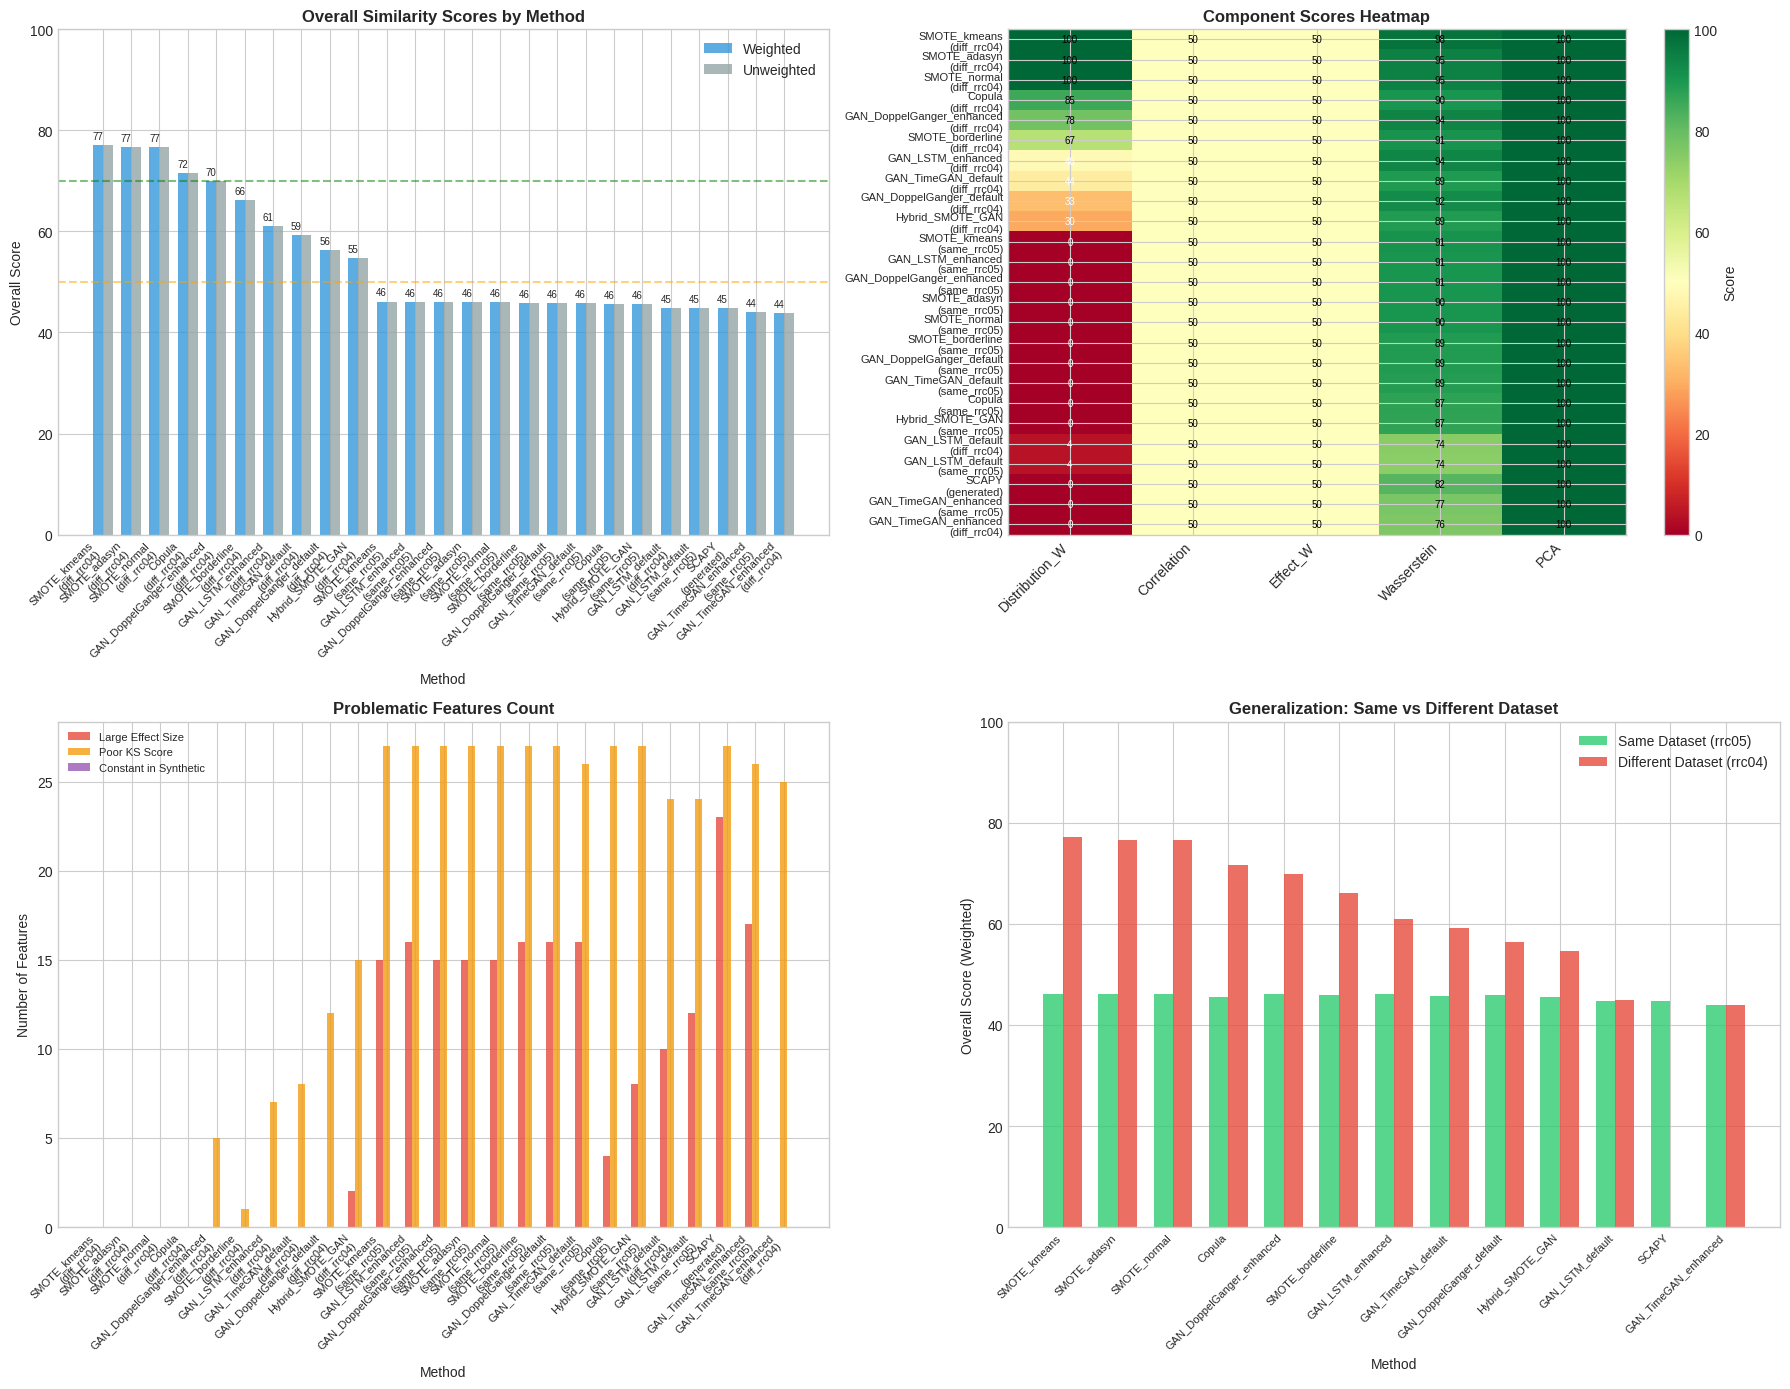

Saved: /home/smotaali/BGP_Traffic_Generation/results_evaluation/comprehensive_evaluation/20260112_233208/overall_comparison.png


In [43]:
if not comparison_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Overall scores bar chart
    ax1 = axes[0, 0]
    methods = comparison_df['Method'] + '\n(' + comparison_df['Comparison'] + ')'
    x = np.arange(len(methods))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, comparison_df['Overall_W'], width, label='Weighted', alpha=0.8, color='#3498db')
    bars2 = ax1.bar(x + width/2, comparison_df['Overall_UW'], width, label='Unweighted', alpha=0.8, color='#95a5a6')
    
    ax1.set_xlabel('Method', fontsize=10)
    ax1.set_ylabel('Overall Score', fontsize=10)
    ax1.set_title('Overall Similarity Scores by Method', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, rotation=45, ha='right', fontsize=8)
    ax1.legend()
    ax1.set_ylim(0, 100)
    ax1.axhline(y=70, color='g', linestyle='--', alpha=0.5, label='Good threshold')
    ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)
    
    # 2. Component scores heatmap
    ax2 = axes[0, 1]
    score_cols = ['Distribution_W', 'Correlation', 'Effect_W', 'Wasserstein', 'PCA']
    score_data = comparison_df[score_cols].values
    
    im = ax2.imshow(score_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    ax2.set_xticks(np.arange(len(score_cols)))
    ax2.set_xticklabels(score_cols, rotation=45, ha='right')
    ax2.set_yticks(np.arange(len(methods)))
    ax2.set_yticklabels(methods, fontsize=8)
    ax2.set_title('Component Scores Heatmap', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax2, label='Score')
    
    # Add text annotations
    for i in range(len(methods)):
        for j in range(len(score_cols)):
            text = ax2.text(j, i, f'{score_data[i, j]:.0f}',
                           ha='center', va='center', fontsize=7,
                           color='white' if score_data[i, j] < 50 else 'black')
    
    # 3. Problematic features count
    ax3 = axes[1, 0]
    issue_cols = ['N_Large_Effect', 'N_Poor_KS', 'N_Const_Syn']
    issue_labels = ['Large Effect Size', 'Poor KS Score', 'Constant in Synthetic']
    
    x = np.arange(len(methods))
    width = 0.25
    colors = ['#e74c3c', '#f39c12', '#9b59b6']
    
    for i, (col, label, color) in enumerate(zip(issue_cols, issue_labels, colors)):
        ax3.bar(x + i * width, comparison_df[col], width, label=label, alpha=0.8, color=color)
    
    ax3.set_xlabel('Method', fontsize=10)
    ax3.set_ylabel('Number of Features', fontsize=10)
    ax3.set_title('Problematic Features Count', fontsize=12, fontweight='bold')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(methods, rotation=45, ha='right', fontsize=8)
    ax3.legend(fontsize=8)
    
    # 4. Same vs Different dataset comparison
    ax4 = axes[1, 1]
    
    same_scores = []
    diff_scores = []
    method_names = []
    
    for method in comparison_df['Method'].unique():
        method_data = comparison_df[comparison_df['Method'] == method]
        same_data = method_data[method_data['Comparison'].str.contains('same|rrc05|generated', case=False)]
        diff_data = method_data[method_data['Comparison'].str.contains('diff|rrc04', case=False)]
        
        if not same_data.empty:
            same_scores.append(same_data['Overall_W'].values[0])
        else:
            same_scores.append(0)
        
        if not diff_data.empty:
            diff_scores.append(diff_data['Overall_W'].values[0])
        else:
            diff_scores.append(0)
        
        method_names.append(method)
    
    x = np.arange(len(method_names))
    width = 0.35
    
    ax4.bar(x - width/2, same_scores, width, label='Same Dataset (rrc05)', alpha=0.8, color='#2ecc71')
    ax4.bar(x + width/2, diff_scores, width, label='Different Dataset (rrc04)', alpha=0.8, color='#e74c3c')
    
    ax4.set_xlabel('Method', fontsize=10)
    ax4.set_ylabel('Overall Score (Weighted)', fontsize=10)
    ax4.set_title('Generalization: Same vs Different Dataset', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(method_names, rotation=45, ha='right', fontsize=8)
    ax4.legend()
    ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/overall_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/overall_comparison.png")
else:
    print("No results to visualize")

## 9. Visualization: Radar Chart Comparison

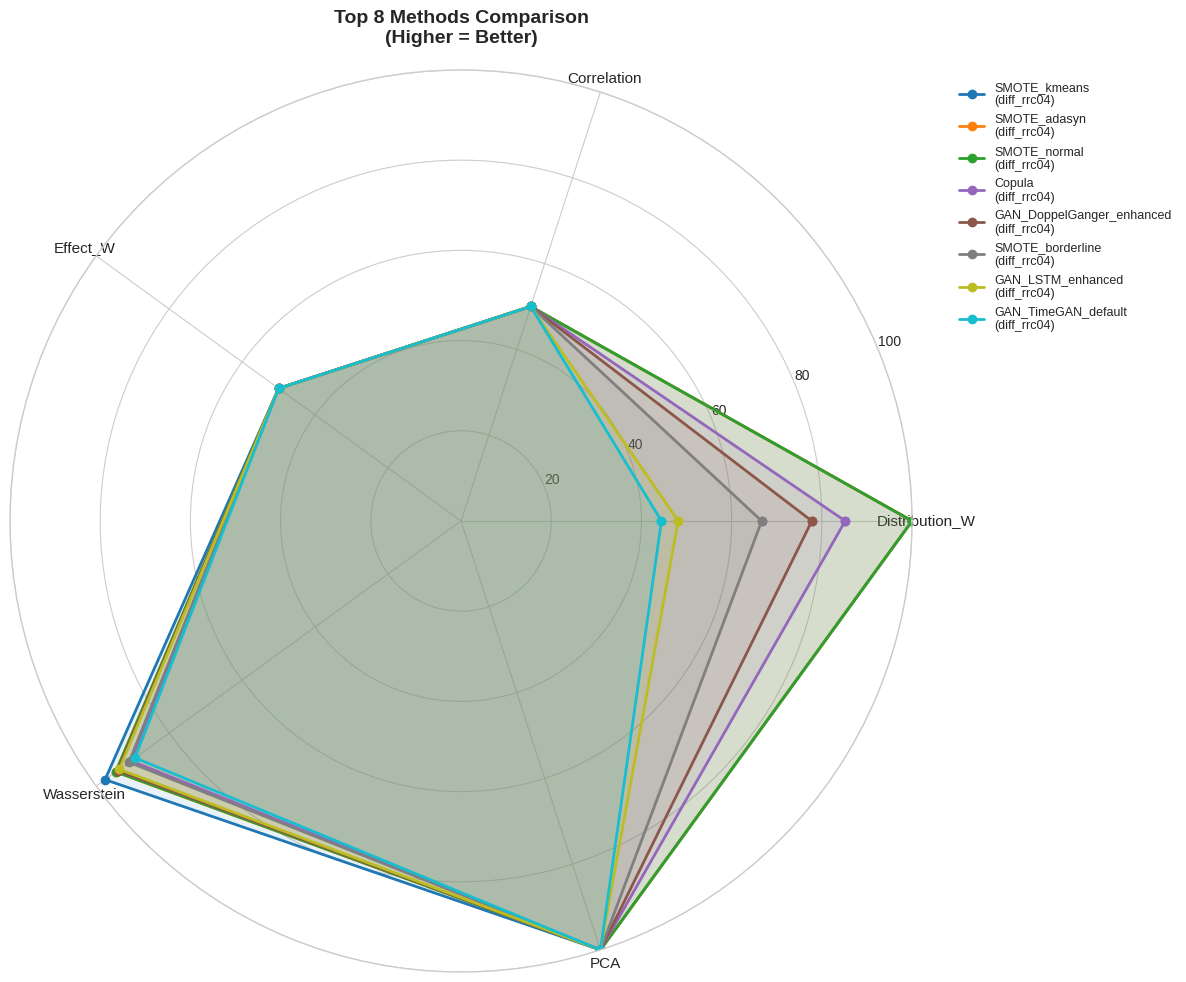

Saved: /home/smotaali/BGP_Traffic_Generation/results_evaluation/comprehensive_evaluation/20260112_233208/radar_comparison.png


In [44]:
if not comparison_df.empty and len(comparison_df) > 0:
    # Get top methods for radar chart
    top_n = min(8, len(comparison_df))
    top_methods = comparison_df.head(top_n)
    
    # Metrics for radar chart
    metrics = ['Distribution_W', 'Correlation', 'Effect_W', 'Wasserstein', 'PCA']
    num_vars = len(metrics)
    
    # Create angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_methods)))
    
    for idx, (_, row) in enumerate(top_methods.iterrows()):
        values = row[metrics].values.flatten().tolist()
        values += values[:1]
        
        label = f"{row['Method']}\n({row['Comparison']})"
        ax.plot(angles, values, 'o-', linewidth=2, label=label, color=colors[idx])
        ax.fill(angles, values, alpha=0.1, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_ylim(0, 100)
    ax.set_title(f'Top {len(top_methods)} Methods Comparison\n(Higher = Better)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/radar_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/radar_comparison.png")
else:
    print("No results to visualize")

## 10. Feature-Level Comparison

In [45]:
# Generate detailed feature comparison table
feature_rows = []

for method_name, method_results in all_results.items():
    for comp_type, result in method_results.items():
        for fm in result['feature_metrics']:
            feature_rows.append({
                'Method': method_name,
                'Comparison': comp_type,
                'Feature': fm['feature'],
                'KS_Statistic': round(fm['ks_statistic'], 4),
                'Wasserstein': round(fm['wasserstein_distance'], 4),
                'Cohens_d': round(fm['cohens_d'], 4),
                'Effect_Interp': fm['cohens_d_interpretation'],
                'Similarity_Level': fm['similarity_level'],
                'Mean_Diff_Pct': round(fm['pct_diff'], 2),
                'Weight': fm['importance_weight']
            })

feature_df = pd.DataFrame(feature_rows)

if not feature_df.empty:
    print("=" * 80)
    print("FEATURE-LEVEL COMPARISON (Sample)")
    print("=" * 80)
    display(feature_df.head(20))
    
    # Save to CSV
    feature_df.to_csv(f'{OUTPUT_DIR}/feature_comparison.csv', index=False)
    print(f"\nSaved: {OUTPUT_DIR}/feature_comparison.csv")
else:
    print("No feature data available")

KeyError: 'pct_diff'

## 11. Feature Heatmap by Method

In [ ]:
if not feature_df.empty:
    # Create pivot table for KS statistic
    pivot_ks = feature_df.pivot_table(
        index='Feature',
        columns=['Method', 'Comparison'],
        values='KS_Statistic',
        aggfunc='mean'
    )
    
    if not pivot_ks.empty and len(pivot_ks.columns) > 0:
        fig, ax = plt.subplots(figsize=(max(14, len(pivot_ks.columns) * 1.2), 
                                        max(10, len(pivot_ks) * 0.35)))
        
        sns.heatmap(pivot_ks, ax=ax, cmap='RdYlGn_r', center=0.1, 
                    annot=True, fmt='.2f', annot_kws={'size': 7},
                    cbar_kws={'label': 'KS Statistic (lower = better)'})
        
        ax.set_title('Feature-wise KS Statistic Comparison\n(Green = Similar, Red = Different)', 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Method & Comparison', fontsize=10)
        ax.set_ylabel('Feature', fontsize=10)
        
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/feature_ks_heatmap.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {OUTPUT_DIR}/feature_ks_heatmap.png")
    else:
        print("Not enough data for heatmap")
else:
    print("No feature data available")

## 12. PCA Visualization for Best Methods

In [ ]:
# Get top 4 methods for PCA visualization
top_methods_for_pca = comparison_df.head(4)

if len(top_methods_for_pca) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(top_methods_for_pca.iterrows()):
        method = row['Method']
        comp = row['Comparison']
        
        if method in all_results and comp in all_results[method]:
            result = all_results[method][comp]
            
            if 'X_pca' in result:
                ax = axes[idx]
                X_pca = result['X_pca']
                labels = result['pca_labels']
                centroid_syn = result['centroid_syn']
                centroid_real = result['centroid_real']
                pca = result['pca']
                
                # Plot points
                mask_syn = labels == 0
                mask_real = labels == 1
                
                ax.scatter(X_pca[mask_syn, 0], X_pca[mask_syn, 1], 
                          c='blue', alpha=0.3, s=10, label='Synthetic')
                ax.scatter(X_pca[mask_real, 0], X_pca[mask_real, 1], 
                          c='red', alpha=0.3, s=10, label='Real')
                
                # Plot centroids
                ax.scatter(centroid_syn[0], centroid_syn[1], c='blue', s=200, 
                          marker='*', edgecolors='black', linewidths=2, 
                          label='Syn Centroid', zorder=5)
                ax.scatter(centroid_real[0], centroid_real[1], c='red', s=200, 
                          marker='*', edgecolors='black', linewidths=2, 
                          label='Real Centroid', zorder=5)
                
                # Draw line between centroids
                ax.plot([centroid_syn[0], centroid_real[0]], 
                       [centroid_syn[1], centroid_real[1]], 
                       'k--', linewidth=2, alpha=0.7)
                
                dist = np.linalg.norm(centroid_syn[:2] - centroid_real[:2])
                ax.annotate(f'd={dist:.2f}', 
                           xy=((centroid_syn[0]+centroid_real[0])/2, 
                               (centroid_syn[1]+centroid_real[1])/2),
                           fontsize=10, fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
                ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
                ax.set_title(f'{method}\n({comp})\nScore: {row["Overall_W"]:.1f}', fontsize=10)
                ax.legend(fontsize=8, loc='upper right')
    
    plt.suptitle('PCA Visualization: Top 4 Methods', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/pca_top_methods.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR}/pca_top_methods.png")
else:
    print("No results available for PCA visualization")

## 13. Summary Report

In [ ]:
print("=" * 80)
print("COMPREHENSIVE TRAFFIC GENERATION EVALUATION - SUMMARY REPORT")
print(f"Generated: {TIMESTAMP}")
print("=" * 80)

if not comparison_df.empty:
    print("\n" + "-" * 40)
    print("RANKING BY OVERALL SCORE (WEIGHTED)")
    print("-" * 40)
    
    for i, (_, row) in enumerate(comparison_df.iterrows()):
        print(f"{i+1}. {row['Method']} ({row['Comparison']}): {row['Overall_W']:.2f}")
    
    print("\n" + "-" * 40)
    print("BEST METHOD BY CATEGORY")
    print("-" * 40)
    
    categories = {
        'Distribution Similarity': 'Distribution_W',
        'Correlation Structure': 'Correlation',
        'Effect Size': 'Effect_W',
        'Wasserstein Distance': 'Wasserstein',
        'Multivariate (PCA)': 'PCA'
    }
    
    for cat_name, col in categories.items():
        best_idx = comparison_df[col].idxmax()
        best_row = comparison_df.loc[best_idx]
        print(f"  {cat_name}: {best_row['Method']} ({best_row['Comparison']}) - {best_row[col]:.2f}")
    
    print("\n" + "-" * 40)
    print("GENERALIZATION ANALYSIS (Same vs Different Dataset)")
    print("-" * 40)
    
    for method in comparison_df['Method'].unique():
        method_data = comparison_df[comparison_df['Method'] == method]
        same_data = method_data[method_data['Comparison'].str.contains('same|rrc05|generated', case=False)]
        diff_data = method_data[method_data['Comparison'].str.contains('diff|rrc04', case=False)]
        
        if not same_data.empty and not diff_data.empty:
            same_score = same_data['Overall_W'].values[0]
            diff_score = diff_data['Overall_W'].values[0]
            drop = same_score - diff_score
            print(f"  {method}: Same={same_score:.2f}, Diff={diff_score:.2f}, Drop={drop:.2f}")
        elif not same_data.empty:
            print(f"  {method}: Same={same_data['Overall_W'].values[0]:.2f}, Diff=N/A")
        elif not diff_data.empty:
            print(f"  {method}: Same=N/A, Diff={diff_data['Overall_W'].values[0]:.2f}")
    
    print("\n" + "-" * 40)
    print("KEY FINDINGS")
    print("-" * 40)
    
    # Best overall method
    best = comparison_df.iloc[0]
    print(f"\n  BEST OVERALL: {best['Method']} ({best['Comparison']})")
    print(f"    Score: {best['Overall_W']:.2f}")
    
    # Method with least issues
    comparison_df['total_issues'] = comparison_df['N_Large_Effect'] + comparison_df['N_Poor_KS'] + comparison_df['N_Const_Syn']
    least_issues = comparison_df.loc[comparison_df['total_issues'].idxmin()]
    print(f"\n  LEAST PROBLEMATIC FEATURES: {least_issues['Method']} ({least_issues['Comparison']})")
    print(f"    Total issues: {least_issues['total_issues']}")
    
    # Best generalization (smallest drop)
    gen_scores = []
    for method in comparison_df['Method'].unique():
        method_data = comparison_df[comparison_df['Method'] == method]
        same_data = method_data[method_data['Comparison'].str.contains('same|rrc05|generated', case=False)]
        diff_data = method_data[method_data['Comparison'].str.contains('diff|rrc04', case=False)]
        
        if not same_data.empty and not diff_data.empty:
            drop = same_data['Overall_W'].values[0] - diff_data['Overall_W'].values[0]
            gen_scores.append((method, drop))
    
    if gen_scores:
        best_gen = min(gen_scores, key=lambda x: x[1])
        print(f"\n  BEST GENERALIZATION: {best_gen[0]}")
        print(f"    Score drop: {best_gen[1]:.2f}")
else:
    print("\nNo evaluation results available.")

print("\n" + "=" * 80)
print("END OF REPORT")
print("=" * 80)

## 14. Save All Results

In [ ]:
# Save summary report as text file
report_text = f"""
{'='*80}
COMPREHENSIVE TRAFFIC GENERATION EVALUATION - SUMMARY REPORT
Generated: {TIMESTAMP}
{'='*80}

METHODS EVALUATED:
"""

if not comparison_df.empty:
    for i, (_, row) in enumerate(comparison_df.iterrows()):
        report_text += f"\n{i+1}. {row['Method']} ({row['Comparison']}): {row['Overall_W']:.2f}"

with open(f'{OUTPUT_DIR}/summary_report.txt', 'w') as f:
    f.write(report_text)
print(f"Saved: {OUTPUT_DIR}/summary_report.txt")

# Save raw results as JSON (simplified version without numpy arrays)
results_json = {}
for method_name, method_results in all_results.items():
    results_json[method_name] = {}
    for comp_type, result in method_results.items():
        results_json[method_name][comp_type] = {
            'n_synthetic': result['n_synthetic'],
            'n_real': result['n_real'],
            'n_features': result['n_features'],
            'overall_scores': result['overall_scores'],
            'correlation_metrics': result['correlation_metrics'],
            'multivariate_metrics': {
                k: v for k, v in result['multivariate_metrics'].items() 
                if k != 'pca_explained_variance' or isinstance(v, (list, float, int))
            },
            'problematic_features': {
                k: v if isinstance(v, list) else [(x[0], float(x[1])) for x in v]
                for k, v in result['problematic_features'].items()
            },
            'constant_features': result['constant_features']
        }

with open(f'{OUTPUT_DIR}/results.json', 'w') as f:
    json.dump(results_json, f, indent=2, default=str)
print(f"Saved: {OUTPUT_DIR}/results.json")

print(f"\nAll results saved to: {OUTPUT_DIR}")